# Задача для Анализа:
В ходе эксперимента целевой группе предложена новая механика оплаты услуг на сайте, в то время как у контрольной группы осталась базовая механика. Задачей является анализ результатов эксперимента и формулирование выводов относительно целесообразности внедрения новой механики оплаты для всех пользователей.

Также создайте функцию, которая автоматически загружает информацию из дополнительного файла groups_add.csv и пересчитывает метрики на основе дополнительных параметров.

И функцию для построения графиков на основе полученных метрик. 

Описание Данных:

- groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

- groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

- active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

- checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

-------------------------------------------------------------------------------------------------------------------------------
### Работа с данными:

Импорт библиотек, необходимых для дальнейшей работы:

In [1]:
import pandas as pd
import requests
from urllib.parse import urlencode
import numpy as np
import scipy
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
import seaborn as sns
import pandahouse as ph
import matplotlib.pyplot as plt

Загрузка датасетов при помощи API с использованием функции:

In [2]:
url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
url_groups = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
url_groups_add = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
url_active_studs = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
url_checks = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

def load_dataframes(url, public_key, sep=';'):
    # Формирую главный url для загрузки данных, добавляя к исходному url параметр public_key
    main = url + urlencode({'public_key': public_key})
    # Отправляю запрос по полученному main через get
    get_url = requests.get(main).json()['href']
    # Из ответа получается url для скачивания данных
    loading_everything = requests.get(get_url)
    # Для считывания использую read_csv
    return pd.read_csv(loading_everything.url, sep=sep)

groups = load_dataframes(url, url_groups)
groups_add = load_dataframes(url, url_groups_add, sep=',')
active_studs = load_dataframes(url, url_active_studs)
checks = load_dataframes(url, url_checks)

Загрузка датафреймов для проверки корректности отображения данных:

In [3]:
groups

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


In [4]:
groups_add

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [5]:
active_studs

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369
...,...
8336,1794344
8337,296883
8338,3598448
8339,3610547


In [6]:
checks

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


Выведение основной информации по датафреймам:

In [7]:
print(groups.info())
print(groups_add.info())
print(active_studs.info())
print(checks.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-

Проверка на пропущенные значения:

In [8]:
missing_values_groups = groups.isnull().sum()
missing_values_groups_add = groups_add.isnull().sum()
missing_values_active_studs = active_studs.isnull().sum()
missing_values_checks = checks.isnull().sum()

print("Пропущенные значения в 'groups':\n", missing_values_groups)
print("Пропущенные значения в 'groups_add':\n", missing_values_groups_add)
print("Пропущенные значения в 'active_studs':\n", missing_values_active_studs)
print("Пропущенные значения в 'checks':\n", missing_values_checks)

Пропущенные значения в 'groups':
 id     0
grp    0
dtype: int64
Пропущенные значения в 'groups_add':
 id     0
grp    0
dtype: int64
Пропущенные значения в 'active_studs':
 student_id    0
dtype: int64
Пропущенные значения в 'checks':
 student_id    0
rev           0
dtype: int64


Проверка на дубликаты:

In [9]:
duplicates_groups = groups.duplicated()
duplicates_groups_add = groups_add.duplicated()
duplicates_active_studs = active_studs.duplicated()
duplicates_checks = checks.duplicated()

if duplicates_groups.any():
    print("Дубликаты в 'groups':\n", duplicates_groups)
else:
    print("Дубликатов в 'groups' нет.")
    
if duplicates_groups_add.any():
    print("Дубликаты в 'groups_add':\n", duplicates_groups_add)
else:
    print("Дубликатов в 'groups_add' нет.")
    
if duplicates_active_studs.any():
    print("Дубликаты в 'active_studs':\n", duplicates_active_studs)
else:
    print("Дубликатов в 'active_studs' нет.")
    
if duplicates_checks.any():
    print("Дубликаты в 'checks':\n", duplicates_checks)
else:
    print("Дубликатов в 'checks' нет.")

Дубликатов в 'groups' нет.
Дубликатов в 'groups_add' нет.
Дубликатов в 'active_studs' нет.
Дубликатов в 'checks' нет.


Подсчёт количества людей в каждой группе датафрейма 'groups':

In [10]:
people_count_in_groups = groups.groupby('grp')['id'].count()

print("Количество людей в каждой группе:\n", people_count_in_groups)

total_people_count = people_count_in_groups.sum()
original_people_count = len(groups)

if total_people_count == original_people_count:
    print("Сумма людей в группах сходится с исходным количеством равным", len(groups))
else:
    print("Сумма людей в группах не сходится с исходным количеством равным", len(groups))

Количество людей в каждой группе:
 grp
A    14671
B    59813
Name: id, dtype: int64
Сумма людей в группах сходится с исходным количеством равным 74484


Подсчёт количества людей в каждой группе датафрейма 'groups_add':

In [11]:
people_count_in_groups_add = groups_add.groupby('grp')['id'].count()

print("Количество людей в каждой группе:\n", people_count_in_groups_add)

total_people_count = people_count_in_groups_add.sum()
original_people_count = len(groups_add)

if total_people_count == original_people_count:
    print("Сумма людей в группах сходится с исходным количеством равным", len(groups_add))
else:
    print("Сумма людей в группах не сходится с исходным количеством равным", len(groups_add))

Количество людей в каждой группе:
 grp
A    22
B    70
Name: id, dtype: int64
Сумма людей в группах сходится с исходным количеством равным 92


Проверка совпадений ID в датафреймах 'groups' и 'groups_add':

In [12]:
common_people = groups['id'].isin(groups_add['id'])

if common_people.any():
    print("Есть схожие люди в столбцах 'id' датафреймов groups и groups_add.")
    common_people_indices = len(groups[common_people].index)
    print("Число общих людей:\n", common_people_indices)
else:
    print("Нет схожих людей в датафреймах groups и groups_add.")


Нет схожих людей в датафреймах groups и groups_add.


Проверка совпадений ID между датафреймами 'groups' + 'groups_add' и 'active_studs':

In [13]:
groups_and_groups_add = pd.concat([groups, groups_add])
common_people = groups_and_groups_add['id'].isin(active_studs['student_id'])

if common_people.any():
    print("Есть схожие люди в столбцах 'id' датафреймов groups_and_groups_add и active_studs.")
    common_people_indices = len(groups_and_groups_add.loc[common_people].index)
    print("Число общих людей:\n", common_people_indices)
else:
    print("Нет схожих людей в датафреймах groups_and_groups_add и active_studs.")

Есть схожие люди в столбцах 'id' датафреймов groups_and_groups_add и active_studs.
Число общих людей:
 8341


Поскольку между датафреймами 'groups' + 'groups_add' и 'active_studs' нашлись совпадающие ID, для упрощения дальнейших действий стоит переименовать колонку 'student_id' в 'id':

In [14]:
active_studs.rename(columns={'student_id': 'id'}, inplace=True)

Проверка совпадений ID между датафреймами 'groups' и 'active_studs' + 'checks':

In [15]:
groups_and_groups_add_active_studs = pd.merge(groups, active_studs, on='id')
common_people = groups_and_groups_add_active_studs['id'].isin(checks['student_id'])

if common_people.any():
    print("Есть схожие люди в столбцах 'id' датафреймов groups_and_groups_add_active_studs и checks.")
    common_people_indices = len(groups_and_groups_add_active_studs.loc[common_people].index)
    print("Число общих людей:\n", common_people_indices)
else:
    print("Нет схожих людей в датафреймах groups_and_groups_add_active_studs и checks.")

Есть схожие люди в столбцах 'id' датафреймов groups_and_groups_add_active_studs и checks.
Число общих людей:
 391


Проверка совпадений ID между датафреймами 'groups' + 'groups_add' и 'active_studs' + 'checks':

In [16]:
groups_and_groups_add = pd.concat([groups, groups_add])
groups_and_groups_add_active_studs = pd.merge(groups_and_groups_add, active_studs, on='id')
common_people_add = groups_and_groups_add_active_studs['id'].isin(checks['student_id'])

if common_people.any():
    print("Есть схожие люди в столбцах 'id' датафреймов groups_and_groups_add_active_studs и checks.")
    common_people_indices_add = len(groups_and_groups_add_active_studs.loc[common_people_add].index)
    print("Число общих людей:\n", common_people_indices_add)
else:
    print("Нет схожих людей в датафреймах groups_and_groups_add_active_studs и checks.")

Есть схожие люди в столбцах 'id' датафреймов groups_and_groups_add_active_studs и checks.
Число общих людей:
 392


Из предыдущих двух проверок ясно, что в датафрейме 'groups_add' есть только один человек, который был активным пользователем (во время проведения эксперимента) и при этом совершил покупку.

Для упрощения дальнейших действий переименуем колонки 'student_id' в 'id' и 'rev' в 'revenue':

In [17]:
checks.rename(columns={'student_id': 'id'}, inplace=True)
checks.rename(columns={'rev': 'revenue'}, inplace=True)

Обратим внимание на уникальные суммы и количество их появлений:

In [18]:
unique_revs_sorted = np.sort(checks['revenue'].unique())
print("Уникальные значения сумм:\n", unique_revs_sorted)

purchases_count_by_person = checks['revenue'].value_counts()
print("Сколько раз встречалась каждая сумма:\n", purchases_count_by_person)


Уникальные значения сумм:
 [ 199.      290.      398.      489.      580.      590.      597.
  630.      690.      796.      840.      870.      880.      990.
 1039.     1050.     1140.     1160.     1180.     1339.     1388.
 1530.     1729.     1830.     1900.     1900.0001 1968.     1980.
 2099.     2190.     2220.     2820.     2890.     2900.     2910.
 3040.     3260.     3660.     4650.    ]
Сколько раз встречалась каждая сумма:
 1900.0000    97
290.0000     94
690.0000     78
199.0000     46
990.0000     41
1900.0001    36
840.0000     27
1140.0000    25
580.0000     15
590.0000     11
398.0000      9
1530.0000     8
870.0000      6
3660.0000     5
2910.0000     4
2890.0000     4
1980.0000     4
2099.0000     3
489.0000      3
1160.0000     3
1180.0000     2
2220.0000     2
2820.0000     2
597.0000      1
1388.0000     1
3260.0000     1
880.0000      1
3040.0000     1
796.0000      1
1968.0000     1
1339.0000     1
4650.0000     1
2900.0000     1
630.0000      1
1830.0000    

Все суммы являются цельночисленными за исключением одной - 1900.0001. Вероятно, это ошибка округления, но мы учтём её в дальнейшем исследовании, чтобы не упустить детали.

In [19]:
purchases_count_by_id = checks.groupby('id')['revenue'].value_counts()
print("Всего людей в checks", len(checks))
print("Количество покупок для каждого id:\n", purchases_count_by_id)

Всего людей в checks 541
Количество покупок для каждого id:
 id       revenue
1627     990.0      1
3185     690.0      1
25973    690.0      1
26280    690.0      1
100300   990.0      1
                   ..
5645737  1900.0     1
5651566  1900.0     1
5662322  1900.0     1
5681918  1900.0     1
5740903  1900.0     1
Name: revenue, Length: 541, dtype: int64


Отсюда следует, что каждый человек из датафрейма 'checks' совершил одну покупку.

Вычисление количества неактивных пользователей, потративших деньги:

In [20]:
print('Число пользователей, потративших деньги:',len(checks))
print('Число активных пользователей, потративших деньги:', common_people_indices)
print('Число неактивных пользователей, потративших деньги:', (len(checks) - common_people_indices))


Число пользователей, потративших деньги: 541
Число активных пользователей, потративших деньги: 391
Число неактивных пользователей, потративших деньги: 150


150 пользователей, потратившие деньги, не были активными. Вероятно, это подписка с автоплатежом
(пользователь не заходил на сайт в процессе покупки), таким образом, их можно не учитывать.

-------------------------------------------------------------------------------------------------------------------------------
Последовательное объединение датафреймов. Итоговая таблица будет отображать данные о всех пользователях (ID, принадлежность к группе, активность, сумма покупки).

In [21]:
groups_active_check = groups.copy()
groups_active_check['active_studs'] = groups_active_check['id'].isin(active_studs['id'])

# Создаю словарь, где ключ id, а значение revenue
revenue_dict = checks.set_index('id')['revenue'].to_dict()

# Добавляю столбец revenue в groups_active_check на основе id
groups_active_check['revenue'] = groups_active_check['id'].map(revenue_dict).fillna(0)
groups_active_check

,id,grp,active_studs,revenue
0,1489,B,False,0.0
1,1627,A,True,990.0
2,1768,B,False,0.0
3,1783,B,False,0.0
4,1794,A,False,0.0
...,...,...,...,...
74479,5692459,B,False,0.0
74480,5692572,B,False,0.0
74481,5692865,B,False,0.0
74482,5693667,B,False,0.0


Узнаем основные значения в группах A и B:

In [22]:
groups_active_check.groupby('grp').revenue.describe()

,count,mean,std,min,25%,50%,75%,max
grp,,,,,,,,
A,14671.0,6.277418,100.866104,0.0,0.0,0.0,0.0,3660.0
B,59813.0,8.013810,113.051542,0.0,0.0,0.0,0.0,4650.0


Построение графиков, предназначенных для визуализации распределения данных по тратам для групп A и B и проверки их соответствия нормальному распределению:

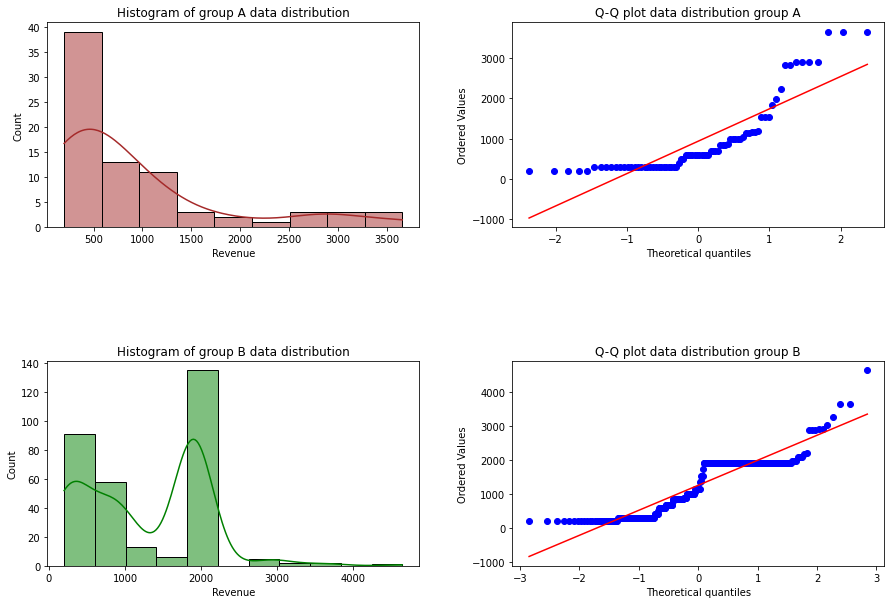

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

sns.histplot(groups_active_check[(groups_active_check['grp'] == 'A') 
                                  & (groups_active_check['active_studs'])
                                  & (groups_active_check['revenue'] > 0)]['revenue'], 
             kde=True, color='#A52A2A', ax=axes[0, 0])
axes[0, 0].set_title('Histogram of group A data distribution')
axes[0, 0].set_xlabel('Revenue')
axes[0, 0].set_ylabel('Count')

stats.probplot(groups_active_check[(groups_active_check['grp'] == 'A') 
                                   & (groups_active_check['active_studs'])
                                   & (groups_active_check['revenue'] > 0)]['revenue'], 
               dist='norm', plot=axes[0, 1])
axes[0, 1].set_title('Q-Q plot data distribution group A')

sns.histplot(groups_active_check[(groups_active_check['grp'] == 'B') 
                                  & (groups_active_check['active_studs'])
                                  & (groups_active_check['revenue'] > 0)]['revenue'], 
             kde=True, color='#008000', ax=axes[1, 0])
axes[1, 0].set_title('Histogram of group B data distribution')
axes[1, 0].set_xlabel('Revenue')
axes[1, 0].set_ylabel('Count')

stats.probplot(groups_active_check[(groups_active_check['grp'] == 'B') 
                                   & (groups_active_check['active_studs'])
                                   & (groups_active_check['revenue'] > 0)]['revenue'], 
               dist='norm', plot=axes[1, 1])
axes[1, 1].set_title('Q-Q plot data distribution group B')
plt.subplots_adjust(wspace=0.25)
plt.subplots_adjust(hspace=0.65)
plt.show()

### Расчёт основных метрик: ARPU, ARPPU, CR:

ARPU

In [24]:
arpu_control = round(groups_active_check[(groups_active_check['grp'] == 'A') 
                                 & (groups_active_check['active_studs'])]['revenue'].mean(), 2)
arpu_target = round(groups_active_check[(groups_active_check['grp'] == 'B') 
                                 & (groups_active_check['active_studs'])]['revenue'].mean(), 2)

arpu = pd.DataFrame({
    'grp': ['A', 'B'],
    'arpu': [arpu_control, arpu_target]})
arpu

,grp,arpu
0,A,47.44
1,B,57.86


ARPPU

In [25]:
arppu_control = round(groups_active_check[(groups_active_check['grp'] == 'A') 
                                 & (groups_active_check['active_studs'])
                                 & (groups_active_check['revenue'] > 0)]['revenue'].mean(), 2)
arppu_target = round(groups_active_check[(groups_active_check['grp'] == 'B') 
                                 & (groups_active_check['active_studs'])
                                 & (groups_active_check['revenue'] > 0)]['revenue'].mean(), 2)

arppu = pd.DataFrame({
    'grp': ['A', 'B'],
    'arppu': [arppu_control, arppu_target]})
arppu

,grp,arppu
0,A,933.59
1,B,1255.83


CR

In [26]:
transactions_control = len(groups_active_check[(groups_active_check['grp'] == 'A') 
                                 & (groups_active_check['active_studs'])]['revenue'])
transactions_target = len(groups_active_check[(groups_active_check['grp'] == 'B') 
                                 & (groups_active_check['active_studs'])])

paid_transactions_control = len(groups_active_check[(groups_active_check['grp'] == 'A') 
                                 & (groups_active_check['active_studs'])
                                 & (groups_active_check['revenue'] > 0)]['revenue'])
paid_transactions_target = len(groups_active_check[(groups_active_check['grp'] == 'B') 
                                 & (groups_active_check['active_studs'])
                                 & (groups_active_check['revenue'] > 0)])

conversion_control_per = round((paid_transactions_control / transactions_control) * 100, 2)
conversion_target_per = round((paid_transactions_target / transactions_target) * 100, 2)

conversion_data = pd.DataFrame({
    'grp': ['A', 'B'],
    'transactions': [transactions_control, transactions_target],
    'paid_transactions': [paid_transactions_control, paid_transactions_target],
    'cr': [conversion_control_per, conversion_target_per]})
conversion_data

,grp,transactions,paid_transactions,cr
0,A,1535,78,5.08
1,B,6793,313,4.61


Результаты расчётов метрик:

In [27]:
all_df = pd.merge(arpu, arppu, on='grp')
all_df = pd.merge(all_df, conversion_data[['grp', 'cr']], on='grp')
all_df

,grp,arpu,arppu,cr
0,A,47.44,933.59,5.08
1,B,57.86,1255.83,4.61


### Проверка метрик на стат. значимость:

ARPU

H0: Средний доход с пользователя в контрольной группе A равен среднему доходу с пользователя в целевой группе B.

H1: Средний доход с пользователя в контрольной группе A не равен среднему доходу с пользователя в целевой группе B.

In [28]:
arpu_test_control = groups_active_check[(groups_active_check['grp'] == 'A') 
                                   & (groups_active_check['active_studs'])]['revenue']
arpu_test_target = groups_active_check[(groups_active_check['grp'] == 'B') 
                                  & (groups_active_check['active_studs'])]['revenue']

statistic, p_value = ttest_ind(arpu_test_control, arpu_test_target)

print('p-значение:', p_value)

if p_value > 0.05:
    print('Не отвергаем нулевую гипотезу: средний доход на пользователя в группах A и B не отличается')
else:
    print('Отвергаем нулевую гипотезу: средний доход на пользователя в группах A и B отличается')

p-значение: 0.2328800964324922
Не отвергаем нулевую гипотезу: средний доход на пользователя в группах A и B не отличается


Исходя из проведённого теста, полученное p-значение равно 0.2329. При уровне значимости 0.05 не отвергается нулевая гипотеза. Таким образом, у нас нет достаточных оснований считать, что средний доход на пользователя в группе A отличается от среднего дохода в группе B.

ARPPU

H0: Средний доход с платящего пользователя в контрольной группе A равен среднему доходу с платящего пользователя в целевой группе B.

H1: Средний доход с платящего пользователя в контрольной группе A не равен среднему доходу с платящего пользователя в целевой группе B.

In [29]:
arppu_test_control = groups_active_check[(groups_active_check['grp'] == 'A') 
                                    & (groups_active_check['active_studs'])
                                    & (groups_active_check['revenue'] > 0)]['revenue']
arppu_test_target = groups_active_check[(groups_active_check['grp'] == 'B') 
                                   & (groups_active_check['active_studs'])
                                   & (groups_active_check['revenue'] > 0)]['revenue']

statistic, p_value = ttest_ind(arppu_test_control, arppu_test_target)

print('p-значение:', p_value)

if p_value > 0.05:
    print('Не отвергаем гипотезу: средний доход на платящего пользователя в группах A и B не отличается')
else:
    print('Отвергаем гипотезу: средний доход на платящего пользователя в группах A и B отличается')

p-значение: 0.001999178025210522
Отвергаем гипотезу: средний доход на платящего пользователя в группах A и B отличается


Исходя из проведённого теста с использованием p-значения 0.002, которое явно меньше уровня значимости 0.05, мы отвергаем нулевую гипотезу. Следовательно, у нас есть статистически значимые доказательства того, что средний доход на пользователя в группе A отличается от среднего дохода на пользователя в группе B.

CR

H0: Конверсионная ставка в контрольной группе A равна конверсионной ставке в целевой группе B.

H1: Конверсионная ставка в контрольной группе A не равна конверсионной ставке в целевой группе B.

In [30]:
data = conversion_data[['transactions', 'paid_transactions']].values

chi2_stat, p_value, _, _ = chi2_contingency(data)

print('p-значение:', p_value)

if p_value > 0.05:
    print('Не отвергаем гипотезу: конверсия в группах A и B не отличается')
else:
    print('Отвергаем гипотезу: конверсия в группах A и B отличается')

p-значение: 0.4912034030799808
Не отвергаем гипотезу: конверсия в группах A и B не отличается


Исходя из результатов теста с использованием критерия хи-квадрат (p-значение равно 0.4912), которое превышает уровень значимости 0.05, мы не имеем достаточных оснований отвергнуть нулевую гипотезу. Таким образом, нет статистически значимых доказательств в пользу того, что конверсионная ставка в группе A отличается от конверсионной ставки в группе B.

### Вывод: В целом, основываясь на проведенных тестах, можно сделать вывод, что средний доход на пользователя и конверсионная ставка не различаются между группами A и B, в то время как средний доход на пользователя отличается. Таким образом, результаты свидетельствуют о том, что новая механика оплаты имеет статистически значимое воздействие на средний чек пользователя. Тем самым, внедрение новой механики имеет смысл.

## Перерасчёт метрик с учётом подгруженных данных из датафрейма 'groups_add':

In [36]:
def recalculate_metrics(df_groups, df_groups_add, df_active_studs, df_checks):

    groups_active_check_groups_add = pd.concat([groups, groups_add])
    groups_active_check_groups_add['active_studs'] = groups_active_check_groups_add['id'].isin(active_studs['id'])
    revenue_dict = checks.set_index('id')['revenue'].to_dict()
    groups_active_check_groups_add['revenue'] = groups_active_check_groups_add['id'].map(revenue_dict).fillna(0)
    
#     ARPU
    arpu_control_with_addition = round(groups_active_check_groups_add[(groups_active_check_groups_add['grp'] == 'A') 
                                 & (groups_active_check_groups_add['active_studs'])]['revenue'].mean(), 2)
    arpu_target_with_addition = round(groups_active_check_groups_add[(groups_active_check_groups_add['grp'] == 'B') 
                                 & (groups_active_check_groups_add['active_studs'])]['revenue'].mean(), 2)
    
#     ARPPU
    arppu_control_with_addition = round(groups_active_check_groups_add[(groups_active_check_groups_add['grp'] == 'A') 
                                 & (groups_active_check_groups_add['active_studs'])
                                 & (groups_active_check_groups_add['revenue'] > 0)]['revenue'].mean(), 2)
    arppu_target_with_addition = round(groups_active_check_groups_add[(groups_active_check_groups_add['grp'] == 'B') 
                                 & (groups_active_check_groups_add['active_studs'])
                                 & (groups_active_check_groups_add['revenue'] > 0)]['revenue'].mean(), 2)

#     CR
    transactions_control_with_addition = len(groups_active_check_groups_add[(groups_active_check_groups_add['grp'] == 'A') 
                                 & (groups_active_check_groups_add['active_studs'])]['revenue'])
    transactions_target_with_addition = len(groups_active_check_groups_add[(groups_active_check_groups_add['grp'] == 'B') 
                                     & (groups_active_check_groups_add['active_studs'])])

    paid_transactions_control_with_addition = len(groups_active_check_groups_add[(groups_active_check_groups_add['grp'] == 'A') 
                                     & (groups_active_check_groups_add['active_studs'])
                                     & (groups_active_check_groups_add['revenue'] > 0)]['revenue'])
    paid_transactions_target_with_addition = len(groups_active_check_groups_add[(groups_active_check_groups_add['grp'] == 'B') 
                                     & (groups_active_check_groups_add['active_studs'])
                                     & (groups_active_check_groups_add['revenue'] > 0)])

    conversion_control_per_with_addition = round((paid_transactions_control_with_addition / transactions_control_with_addition) * 100, 2)
    conversion_target_per_with_addition = round((paid_transactions_target_with_addition / transactions_target_with_addition) * 100, 2)

    metrics = pd.DataFrame({
        'grp': ['A', 'B'],
        'arpu': [arpu_control_with_addition, arpu_target_with_addition],
        'arppu': [arppu_control_with_addition, arppu_target_with_addition],
        'cr': [conversion_control_per_with_addition, conversion_target_per_with_addition]
    })
    
    return metrics

Результаты перерасчёта:

In [37]:
final_df = recalculate_metrics(groups, groups_add, checks, active_studs)
final_df

,grp,arpu,arppu,cr
0,A,47.35,933.59,5.07
1,B,58.06,1257.88,4.62


Функция построения графиков полученных метрик:

In [38]:
def visualization(data):   
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    # ARPU
    sns.barplot(data = data, y='arpu', x='grp', ax=axes[0], palette=['#FFA07A','#3CB371'])
    axes[0].set(xlabel='Group')
    axes[0].set(ylabel='Monetary Units')
    axes[0].set_title('ARPU')
    # ARPPU
    sns.barplot(data = data, y='arppu', x='grp', ax=axes[1], palette=['#FFA07A','#3CB371'])
    axes[1].set(xlabel='Group')
    axes[1].set(ylabel='Monetary Units')
    axes[1].set_title('ARPPU')
    # CR
    sns.barplot(data = data, y = 'cr', x = 'grp', ax=axes[2], palette=['#FFA07A','#3CB371'])
    axes[2].set(xlabel='Group')
    axes[2].set(ylabel='Percentage Points')
    axes[2].set_title('CR')
    
    plt.subplots_adjust(wspace=0.5)

Построенные графики:

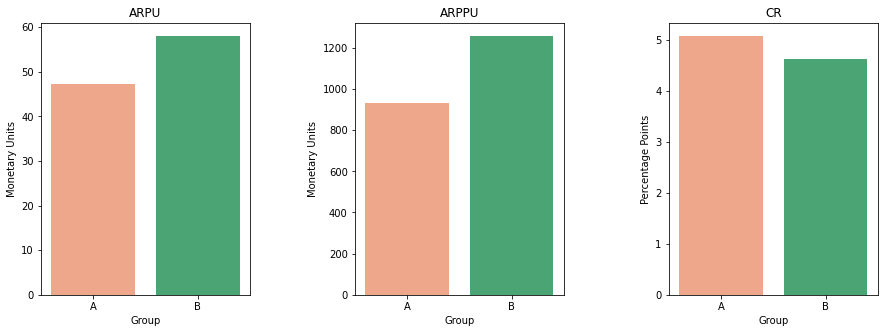

In [39]:
visualization(final_df)

-------------------------------------------------------------------------------------------------------------------------------
## SQL (1 задача)

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание будем называть подзадачей.

Напишите оптимальный SQL-запрос для получения информации о количестве очень усердных студентов. Определите усердных студентов как тех, кто правильно решил как минимум 20 задач за текущий месяц.

Описание Данных:

- default.peas:

Название атрибута	Тип атрибута	Смысловое значение

st_id	int	ID ученика

timest	timestamp	Время решения карточки

correct	bool	Правильно ли решена подзадача?

subject	text	Дисциплина, в которой находится подзадача


In [31]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [32]:
q1 = '''
    SELECT
        COUNT(DISTINCT st_id) AS total_people
    FROM
        default.peas
    WHERE
        st_id IN (
            SELECT st_id
            FROM default.peas
            GROUP BY st_id
            HAVING SUM(correct) >= 20
            AND EXTRACT(MONTH FROM MAX(timest))
        )
    '''

In [33]:
answer1 = ph.read_clickhouse(query=q1, connection=connection)
answer1

,total_people
0,136


## SQL (2 задача)

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 подзадач в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.


Описание Данных: 

- default.peas:

Название атрибута	Тип атрибута	Смысловое значение

st_id	int	ID ученика

timest	timestamp	Время решения карточки

correct	bool	Правильно ли решена подзадача?

subject	text	Дисциплина, в которой находится подзадача

- default.studs:

Название атрибута	Тип атрибута	Смысловое значение

st_id	int	 ID ученика

test_grp	text	 Метка ученика в данном эксперименте


- default.final_project_check:

Название атрибута	Тип атрибута	Смысловое значение

st_id	int 	ID ученика

sale_time	timestamp	Время покупки

money	int	Цена, по которой приобрели данный курс

subject	text 	

----
Напишите SQL-запрос для получения следующей информации о группах пользователей:

ARPU

ARPAU

CR в покупку

CR активного пользователя в покупку

CR пользователя из активности по математике в покупку курса по математике

(Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.)


In [34]:
q2 = '''
    WITH user_activity AS 
        (
        SELECT 
            st_id
        FROM 
            default.peas
        GROUP BY 
            st_id
        HAVING COUNT(correct) > 10
        ),
    user_activity_math AS
        (
        SELECT
            st_id
        FROM
            default.peas
        WHERE
            subject = 'Math'
        GROUP BY 
            st_id
        HAVING 
            COUNT(correct) >= 2
        )

    SELECT 
        s.test_grp AS group,
        SUM(fp.money) / COUNT(DISTINCT s.st_id) AS ARPU,
        SUM(fp.money) / COUNT(DISTINCT ua.st_id) AS ARPAU,
        ROUND((COUNT(DISTINCT fp.st_id) / COUNT(DISTINCT s.st_id) * 100), 2) AS CR_for_purchase,
        ROUND((COUNT(DISTINCT CASE WHEN fp.st_id IN (SELECT st_id FROM user_activity) THEN fp.st_id END) / COUNT(DISTINCT ua.st_id) * 100), 2) AS CR_AU_for_purchase,
        ROUND((COUNT(DISTINCT CASE WHEN fp.st_id IN (SELECT st_id FROM user_activity_math) THEN fp.st_id END) / COUNT(DISTINCT uam.st_id) * 100), 2)  AS CR_math_purchase
    FROM 
        default.studs AS s
    LEFT JOIN user_activity ua ON s.st_id = ua.st_id
    LEFT JOIN user_activity_math uam ON s.st_id = uam.st_id
    LEFT JOIN default.final_project_check fp ON s.st_id = fp.st_id
    GROUP BY
        s.test_grp
    '''

In [35]:
answer2 = ph.read_clickhouse(query=q2, connection=connection)
answer2

,group,ARPU,ARPAU,CR_for_purchase,CR_AU_for_purchase,CR_math_purchase
0,control,4540.983607,9111.842105,5.25,9.87,11.76
1,pilot,11508.474576,27827.868852,11.19,21.31,13.33


### Вывод: 
- Группа "pilot" имеет более высокие показатели ARPU и ARPAU по сравнению с группой "control".

- Конверсия в покупку (CR_for_purchase) в группе "pilot" также выше, что свидетельствует о более эффективной монетизации.

- CR_AU_for_purchase и CR_math_purchase также показывают преимущество группы "pilot" в привлечении активных пользователей и пользователей, активных в математике, соответственно.

### Общий вывод: Эксперимент с новым экраном оплаты (группа "pilot") привел к улучшению ключевых показателей монетизации и привлечения активных пользователей, что делает его более успешным по сравнению с группой "control". Рекомендуется продолжить использование нового экрана оплаты.